In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

import re

import time
import pickle

from functions import *

%load_ext autoreload
%autoreload 2

pd.set_option('max_colwidth', 150)

In [4]:
df = pd.read_csv('data/poetry_foundation_genres_first_features.csv', index_col=0)
df.head()

,poet_url,genre,poem_url,poet,title,poem_lines,poem_string,clean_lines,num_lines,avg_len_line
0,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48578/at-the-california-institute-of-technology,Richard Brautigan,At the California Institute of Technology,"['I don’t care how God-damn smart', '\r these guys are: I’m bored.', '', '\r It’s been raining like hell all day long', '\r and there’s nothing to...",I don’t care how God-damn smart\n\r these guys are: I’m bored.\n\n\r It’s been raining like hell all day long\n\r and there’s nothing to do.\n,"['I don’t care how God-damn smart', 'these guys are: I’m bored.', 'It’s been raining like hell all day long', 'and there’s nothing to do.']",4,6.000000
1,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48576/a-boat,Richard Brautigan,A Boat,"['O beautiful ', 'was the werewolf ', 'in his evil forest. ', 'We took him ', 'to the carnival ', 'and he started ', ' crying ', 'when h...",O beautiful \nwas the werewolf \nin his evil forest. \nWe took him \nto the carnival \nand he started \n crying \nwhen he saw \nthe Ferr...,"['O beautiful', 'was the werewolf', 'in his evil forest.', 'We took him', 'to the carnival', 'and he started', 'crying', 'when he saw', 'the Ferri...",17,2.647059
2,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48580/december-30,Richard Brautigan,December 30,"['At 1:03 in the morning a fart', '\r smells like a marriage between', '\r an avocado and a fish head.', '', '\r I have to get out of bed', '\r to...",At 1:03 in the morning a fart\n\r smells like a marriage between\n\r an avocado and a fish head.\n\n\r I have to get out of bed\n\r to write this ...,"['At 1:03 in the morning a fart', 'smells like a marriage between', 'an avocado and a fish head.', 'I have to get out of bed', 'to write this down...",6,5.500000
3,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48579/the-double-bed-dream-gallows,Richard Brautigan,The Double-Bed Dream Gallows,"['Driving through ', '\r hot brushy country', '\r in the late autumn, ', '\r I saw a hawk', '\r crucified on a', '\r barbed-wire fence.', '', ...","Driving through \n\r hot brushy country\n\r in the late autumn, \n\r I saw a hawk\n\r crucified on a\n\r barbed-wire fence.\n\n\r I guess as a...","['Driving through', 'hot brushy country', 'in the late autumn,', 'I saw a hawk', 'crucified on a', 'barbed-wire fence.', 'I guess as a kind', 'of ...",17,3.176471
4,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48581/haiku-ambulance,Richard Brautigan,Haiku Ambulance,"['A piece of green pepper', '\r fell', '\r off the wooden salad bowl:', '\r so what?', '']",A piece of green pepper\n\r fell\n\r off the wooden salad bowl:\n\r so what?\n,"['A piece of green pepper', 'fell', 'off the wooden salad bowl:', 'so what?']",4,3.250000


In [3]:
df.shape

(4291, 10)

##### Saving to CSV converts the poem_lines lists into a string, so we'll use our destringify function to convert it back to a list format.

In [5]:
df.loc[0,'poem_lines']

"['I don’t care how God-damn smart', '\\r these guys are: I’m bored.', '', '\\r It’s been raining like hell all day long', '\\r and there’s nothing to do.', '']"

In [6]:
df['poem_lines'] = df['poem_lines'].apply(destringify)
df.loc[0,'poem_lines']

['I don’t care how God-damn smart',
 '\r these guys are: I’m bored.',
 '',
 '\r It’s been raining like hell all day long',
 '\r and there’s nothing to do.',
 '']

##### Let's look at our class imbalance.

In [7]:
# poems per genre
df.genre.value_counts()

modern                            1136
victorian                          643
romantic                           397
imagist                            315
new_york_school                    239
black_mountain                     234
language_poetry                    191
new_york_school_2nd_generation     177
black_arts_movement                162
georgian                           158
confessional                       153
harlem_renaissance                 142
beat                               138
objectivist                        132
fugitive                            74
Name: genre, dtype: int64

In [8]:
# percentage of total poems per genre
df.genre.value_counts(normalize=True)

modern                            0.264740
victorian                         0.149849
romantic                          0.092519
imagist                           0.073409
new_york_school                   0.055698
black_mountain                    0.054533
language_poetry                   0.044512
new_york_school_2nd_generation    0.041249
black_arts_movement               0.037753
georgian                          0.036821
confessional                      0.035656
harlem_renaissance                0.033093
beat                              0.032160
objectivist                       0.030762
fugitive                          0.017245
Name: genre, dtype: float64

In [10]:
# number of unique poets per genre
{genre:len(poets) for genre,poets in df.groupby('genre').poet.unique().items()}

{'beat': 13,
 'black_arts_movement': 18,
 'black_mountain': 10,
 'confessional': 9,
 'fugitive': 7,
 'georgian': 18,
 'harlem_renaissance': 14,
 'imagist': 7,
 'language_poetry': 14,
 'modern': 52,
 'new_york_school': 10,
 'new_york_school_2nd_generation': 16,
 'objectivist': 5,
 'romantic': 50,
 'victorian': 56}

##### Let's look at our new continuous variables, as a whole and by genre

In [12]:
df.describe()

,num_lines,avg_len_line
count,4291.000000,4291.000000
mean,36.320671,6.838280
std,60.071109,13.770607
min,1.000000,1.000000
25%,14.000000,5.027778
50%,21.000000,6.227273
75%,32.000000,7.452027
max,892.000000,808.000000


In [13]:
df.groupby('genre').describe().T

genre                     beat  black_arts_movement  black_mountain  \
num_lines    count  138.000000           162.000000      234.000000   
             mean    43.355072            41.938272       29.880342   
             std     54.772229            33.790125       32.050567   
             min      4.000000             1.000000        3.000000   
             25%     17.000000            21.000000       15.250000   
             50%     25.500000            31.000000       23.000000   
             75%     43.750000            54.750000       29.000000   
             max    331.000000           157.000000      256.000000   
avg_len_line count  138.000000           162.000000      234.000000   
             mean     6.810101             6.699416        5.090879   
             std      4.595840             6.982837        6.440844   
             min      1.307692             2.840000        1.571429   
             25%      4.731410             4.711180        3.597222   
             50%      5.646259             5.776786        4.500000   
             75%      7.120074             7.282468        5.589286   
             max     32.181818            88.000000      100.500000   

genre               confessional    fugitive    georgian  harlem_renaissance  \
num_lines    count    153.000000   74.000000  158.000000          142.000000   
             mean      42.320261   28.270270   23.949367           24.169014   
             std       61.581958   40.220726   18.484560           32.455310   
             min        4.000000    5.000000    2.000000            1.000000   
             25%       18.000000   14.000000   13.250000           12.000000   
             50%       26.000000   20.000000   19.000000           16.000000   
             75%       42.000000   27.000000   26.000000           24.000000   
             max      515.000000  323.000000  143.000000          249.000000   
avg_len_line count    153.000000   74.000000  158.000000          142.000000   
             mean       6.590835    7.459002    6.687811            6.291038   
             std        1.504047    1.099102    1.435607            3.608594   
             min        2.888889    4.607143    3.500000            1.801136   
             25%        5.657143    7.008621    5.666667            4.535059   
             50%        6.416667    7.464461    6.569712            5.781746   
             75%        7.450000    8.077110    7.757500            7.383929   
             max       16.340708   11.250000   13.500000           33.800000   

genre                  imagist  language_poetry       modern  new_york_school  \
num_lines    count  315.000000       191.000000  1136.000000       239.000000   
             mean    23.942857        35.560209    24.395246        32.338912   
             std     29.659263        45.982666    36.322825        33.312220   
             min      1.000000         1.000000     1.000000         2.000000   
             25%     11.000000        18.000000    12.000000        18.500000   
             50%     19.000000        24.000000    18.000000        25.000000   
             75%     24.000000        36.000000    24.000000        33.500000   
             max    256.000000       476.000000   605.000000       383.000000   
avg_len_line count  315.000000       191.000000  1136.000000       239.000000   
             mean     6.067738         6.975177     6.672186         7.744362   
             std      7.343963        17.999521     6.262389         4.390220   
             min      1.421053         1.000000     1.333333         2.523810   
             25%      4.074176         3.183333     5.129076         5.953347   
             50%      5.166667         4.411765     6.176786         7.175000   
             75%      6.250000         7.328829     7.292279         8.309524   
             max    105.666667       235.000000   139.000000        42.500000   

genre               new_york_school_2nd_generation  o

##### Let's look at some boxplots of this information

In [28]:
# prettify the labels
genre_list_pretty = [genre.replace('_', '\n').title() for genre in df.genre.unique()]
genre_list_pretty[1] = 'Black Arts\nMovement'
genre_list_pretty[-5] = 'New York\nSchool'
genre_list_pretty[-4] = 'New York School\n2nd Generation'

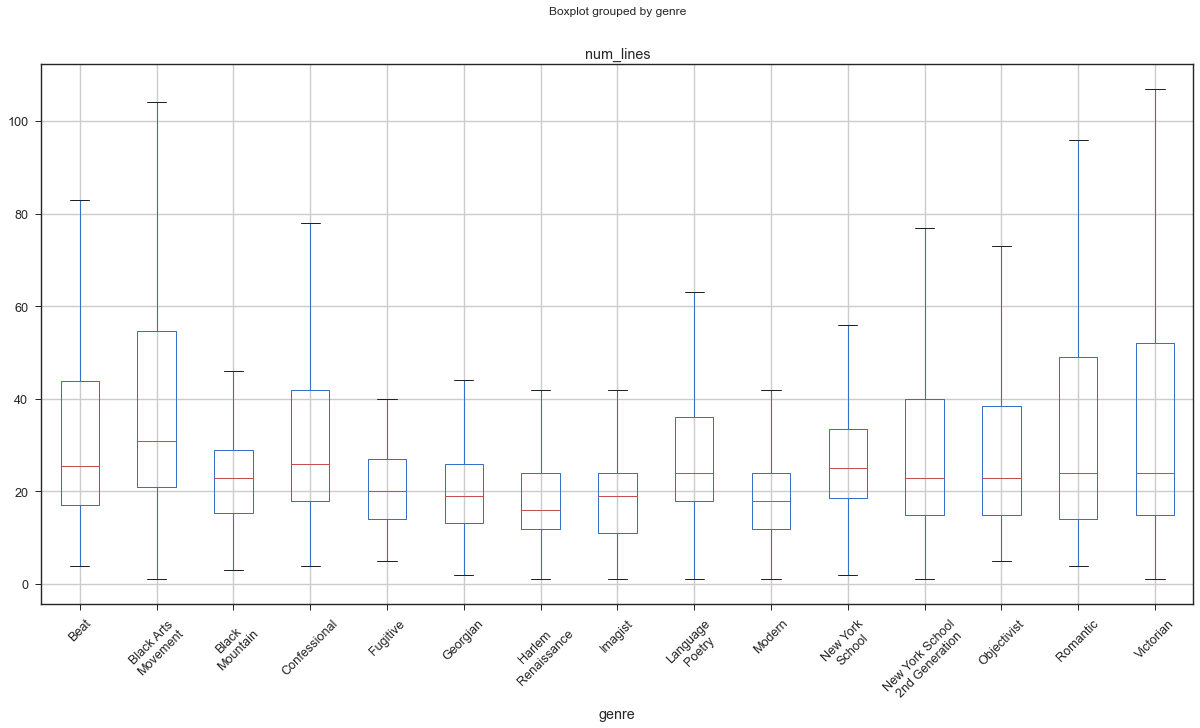

In [29]:
sns.set_style('ticks')

df.boxplot('num_lines', 'genre', showfliers=False, figsize=(20,10))
plt.xticks(ticks=range(1, len(genre_list_pretty)+1), labels=genre_list_pretty, rotation=45);

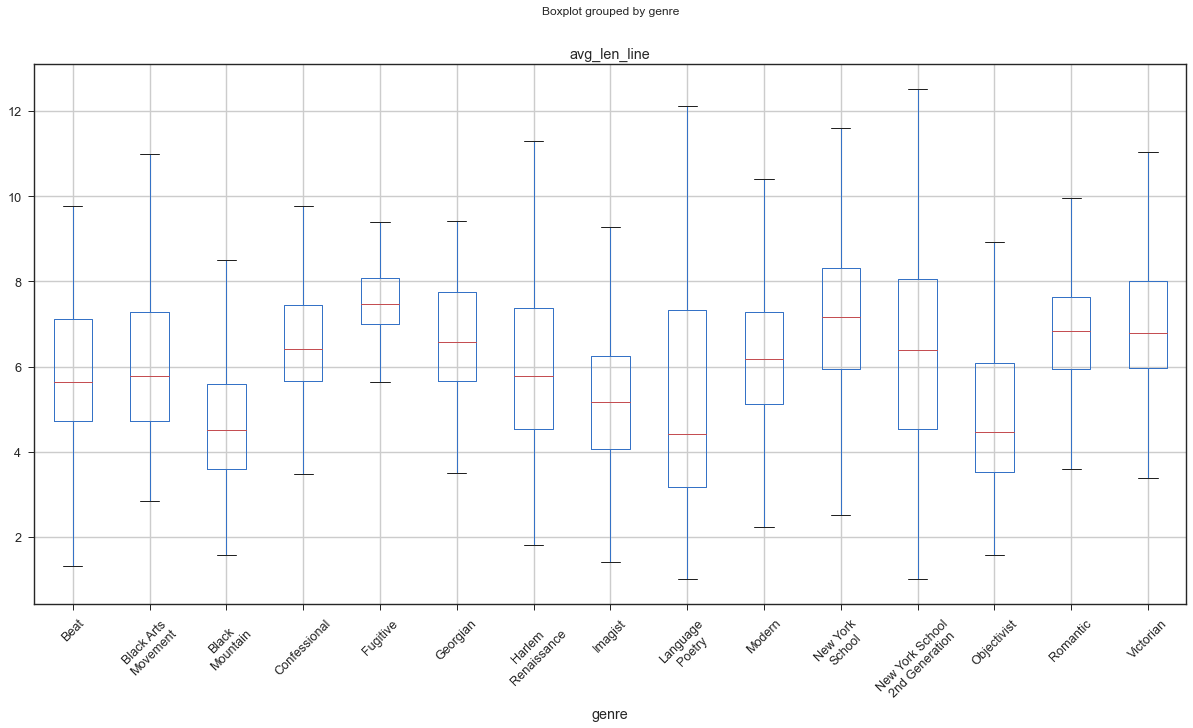

In [30]:
df.boxplot('avg_len_line', 'genre', showfliers=False, figsize=(20,10))
plt.xticks(ticks=range(1, len(genre_list_pretty)+1), labels=genre_list_pretty, rotation=45);